## Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# model 
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, Embedding, LSTM, Dense
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from sklearn import metrics
from sklearn.model_selection import train_test_split

# word embedding
import gensim 
from gensim.models import Word2Vec

## Upload data

In [4]:
# load data
from google.colab import drive
drive.mount('/gdrive')

%cd '/gdrive/My Drive/data/nofakenews'
%ls

Mounted at /gdrive
/gdrive/My Drive/data/nofakenews
fake.csv  true.csv


## Explore datasets

In [5]:
# load datasets
fake = pd.read_csv('fake.csv')
true = pd.read_csv('true.csv')

In [6]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
# label datasets
fake['label'] = 1
true['label'] = 0

In [9]:
# remove unnecessary columns
fake = fake.drop(['subject', 'title', 'date'], axis=1)
true = true.drop(['subject', 'title', 'date'], axis=1)

In [10]:
# merge both datasets
df = pd.concat([fake, true])

# randomly shuffle rows
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

df.head(10)

,text,label
0,(Reuters) - Ten Republican state attorneys gen...,0
1,White House press secretary Sean Spicer went t...,1
2,ISTANBUL/KHARTOUM (Reuters) - Turkey will rebu...,0
3,ROME (Reuters) - The Italian government called...,0
4,SYDNEY (Reuters) - Australia will not be allow...,0
5,What a brave boy and what a sad world we live ...,1
6,21st Century Wire says After a long drawn out ...,1
7,Christian fundamentalists just can t keep thei...,1
8,21st Century Wire says Are we already seeing t...,1
9,"Yesterday, on the first day of the Republican ...",1


## Preparing data

In [11]:
# checking info of datasets
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


,label
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [12]:
# delete duplicates if any
df.drop_duplicates(subset=None, keep='first', inplace=True)
df.reset_index(inplace=True, drop=True)

df.describe()

,label
count,38647.000000
mean,0.451652
std,0.497663
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


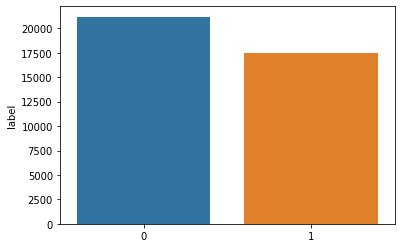

In [13]:
# plotting class distribution
x = df['label'].value_counts()
sns.barplot(x.index, x)

## Text processing

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
def clean(sentence):
  sentence = sentence.lower()
  sentence = sentence.replace('https://', ' ')
  sentence = sentence.replace('http://', ' ')
  sentence = re.sub('[^a-zA-Z0-9 ]', ' ', sentence)

  sentence = " ".join(sentence.split())

  filtered = []
  for word in sentence.split():
    if word not in stop_words:
      filtered.append(word)
  
  sentence = " ".join(filtered)
  sentence = "".join([lemmatizer.lemmatize(word) for word in sentence])

  return sentence

In [16]:
df['clean_text'] = df['text'].apply(lambda x: clean(x))
df.head()

,text,label,clean_text
0,(Reuters) - Ten Republican state attorneys gen...,0,reuters ten republican state attorneys general...
1,White House press secretary Sean Spicer went t...,1,white house press secretary sean spicer went s...
2,ISTANBUL/KHARTOUM (Reuters) - Turkey will rebu...,0,istanbul khartoum reuters turkey rebuild ruine...
3,ROME (Reuters) - The Italian government called...,0,rome reuters italian government called tuesday...
4,SYDNEY (Reuters) - Australia will not be allow...,0,sydney reuters australia allowed walk away leg...


In [17]:
corpus = [text for text in df['clean_text']]
corpus[0]

'reuters ten republican state attorneys general thursday urged federal authorities rescind policy set former u president barack obama protects deportation nearly 600 000 immigrants brought country illegally parents known dreamers obama democrat hoped overhauling u immigration system resolving fate estimated 11 million people country illegally would part presidential legacy republican president donald trump vowed crack illegal immigration department homeland security earlier month rescinded separate obama era policy meant cover illegal immigrant parents blocked courts however dhs said deferred action childhood arrivals daca policy covering dreamers still effect letter thursday republican attorneys general asked dhs abolish daca program going forward noting government rescind permits already issued federal government withdraw daca attorneys general said would file legal challenge program federal court texas dhs representative referred questions u department justice immediately respond re

In [18]:
one_hot_encoded = [one_hot(text, 10000) for text in corpus]
m = max([len(text) for text in one_hot_encoded])
m

5069

In [19]:
emb_doc = tf.keras.preprocessing.sequence.pad_sequences(
    one_hot_encoded, 
    maxlen=m, 
    padding="pre"
)

## Model training

In [20]:
model = Sequential()
model.add(Embedding(10000, 64, input_length=m))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="acc"
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5069, 64)          640000    
                                                                 
 dropout (Dropout)           (None, 5069, 64)          0         
                                                                 
 lstm (LSTM)                 (None, 256)               328704    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


In [21]:
# splitting dataset
x_train, x_test, y_train, y_test = train_test_split(
    np.array(emb_doc),
    df['label'],
    random_state=0,
    test_size=0.3
)

In [22]:
# fit model
hist = model.fit(
    x_train, 
    y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=10
)

Epoch 1/10
381/381 [==============================] - 139s 345ms/step - loss: 0.1631 - acc: 0.9430 - val_loss: 0.0790 - val_acc: 0.9771
Epoch 2/10
381/381 [==============================] - 135s 355ms/step - loss: 0.0509 - acc: 0.9847 - val_loss: 0.0372 - val_acc: 0.9908
Epoch 3/10
381/381 [==============================] - 136s 358ms/step - loss: 0.0742 - acc: 0.9732 - val_loss: 0.2193 - val_acc: 0.9150
Epoch 4/10
381/381 [==============================] - 136s 357ms/step - loss: 0.0839 - acc: 0.9699 - val_loss: 0.0664 - val_acc: 0.9834
Epoch 5/10
381/381 [==============================] - 141s 370ms/step - loss: 0.0558 - acc: 0.9807 - val_loss: 0.3675 - val_acc: 0.8271
Epoch 6/10
381/381 [==============================] - 137s 358ms/step - loss: 0.1851 - acc: 0.9352 - val_loss: 0.1675 - val_acc: 0.9357
Epoch 7/10
381/381 [==============================] - 141s 371ms/step - loss: 0.0736 - acc: 0.9726 - val_loss: 0.0990 - val_acc: 0.9605
Epoch 8/10
381/381 [============================

In [23]:
hist.history

{'acc': [0.9429885745048523,
  0.9847202897071838,
  0.9732193946838379,
  0.9699334502220154,
  0.9806950092315674,
  0.9352254867553711,
  0.9726443886756897,
  0.9878830313682556,
  0.9937566518783569,
  0.9938388466835022],
 'loss': [0.16305941343307495,
  0.05094272643327713,
  0.07418578863143921,
  0.0838978961110115,
  0.05582165718078613,
  0.1851232498884201,
  0.07363658398389816,
  0.035398900508880615,
  0.01960853673517704,
  0.018999574705958366],
 'val_acc': [0.9770879745483398,
  0.9907612800598145,
  0.9150037169456482,
  0.983370304107666,
  0.8270509839057922,
  0.9356984496116638,
  0.9604582190513611,
  0.956023633480072,
  0.9708056449890137,
  0.9826312065124512],
 'val_loss': [0.07902781665325165,
  0.03718521073460579,
  0.21929404139518738,
  0.06643856316804886,
  0.3674991726875305,
  0.16750536859035492,
  0.09899869561195374,
  0.13516798615455627,
  0.09169450402259827,
  0.06672845780849457]}

Text(0.5, 1.0, 'Accuracy')

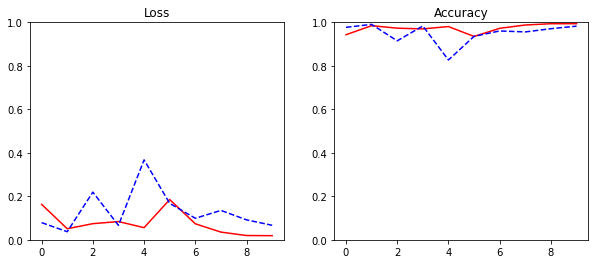

In [26]:
# loss-accuracy visualisation
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], color="red")
plt.plot(hist.history['val_loss'], color="blue", linestyle="--")
plt.ylim(0, 1)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], color="red")
plt.plot(hist.history['val_acc'], color="blue", linestyle="--")
plt.ylim(0, 1)
plt.title("Accuracy")

## Model evaluation

In [27]:
# check predictions
prediction = model.predict(x_test)
y_prediction = np.where(prediction > 0.5, 1, 0)

In [28]:
model.evaluate(y_test, y_prediction)

363/363 [==============================] - 1s 3ms/step - loss: 1.6153 - acc: 0.5537


[1.6152616739273071, 0.5536869168281555]

In [29]:
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_prediction)}")
print(f"Confusion matrix: {metrics.confusion_matrix(y_test, y_prediction)}")
print(metrics.classification_report(y_test, y_prediction))

Accuracy score: 0.9767141009055628
Confusion matrix: [[6275  125]
 [ 145 5050]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6400
           1       0.98      0.97      0.97      5195

    accuracy                           0.98     11595
   macro avg       0.98      0.98      0.98     11595
weighted avg       0.98      0.98      0.98     11595



## Saving model

In [30]:
model.save('nofakenews.h5')